In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from torch.utils.data import TensorDataset, Dataset, DataLoader

datapath = "/home/sysop/pytorch/Data/"
outpath = "/home/sysop/pytorch/Output/"

### Training Data

In [4]:
st = read(datapath + "0121Dapu.mseed")
t1 = UTCDateTime(2025, 1, 20, 16, 17, 16)
t2 = UTCDateTime(2025, 1, 20, 16, 17, 34)
st2 = st.slice(t2, t2+5)

st2.normalize()
st2.detrend("linear")

waveforms, stations, labels = [], [], []
for i in st2:
    waveforms.append(i.data)
    stations.append("0121Dapu_"+i.stats.station)
    if i.stats.station in ["ALS", "CHN8", "CHY", "SCL", "ELD", "SSD", "TAI", "TAI1", "WDL", "WGK", "WSF", "YUS"]:
        labels.append(1)
    else:
        labels.append(0)

In [5]:
st = read(datapath + "0130Dapu.mseed")
t1 = UTCDateTime(2025, 1, 30, 2, 12, 6)
t2 = UTCDateTime(2025, 1, 30, 2, 12, 11)
st2 = st.slice(t1, t2)

st2.normalize()
st2.detrend("linear")

# waveforms, stations, labels = [], [], []
for i in st2:
    if i.stats.station == "ENA":
        continue
    else:
        waveforms.append(i.data)
        stations.append("0130Dapu_"+i.stats.station)
        if i.stats.station in ["CHK", "ECL", "ECS", "SGL", "SML", "SPT", "TTN", "WDG", "WNT", "WTC", "WYL"]:
            labels.append(1)
        else:
            labels.append(0)

In [6]:
st = read(datapath + "0611Hualien.mseed")
t1 = UTCDateTime(2025, 6, 11, 11, 0, 51)
t2 = UTCDateTime(2025, 6, 11, 11, 0, 56)
st2 = st.slice(t1, t2)

st2.normalize()
st2.detrend("linear")

# waveforms, stations, labels = [], [], []
for i in st2:
    waveforms.append(i.data)
    stations.append("0130Dapu_"+i.stats.station)
    if i.stats.station in ["CHN8", "EAS", "HSN1", "ILA", "LAY", "NJD", "NJN", "NML", "NSK", "NST", "NSY",
                          "SCL", "SCZ", "SGL", "SPT", "SSH", "TAI1", "WSF", "WTC", "WWC"]:
        labels.append(1)
    else:
        labels.append(0)

### Model

In [7]:
class SeismicDataset(Dataset):
    def __init__(self, waveforms, labels, stations):
        self.waveforms = waveforms
        self.labels = labels
        self.stations = stations

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        waveform = torch.tensor(self.waveforms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        station = self.stations[idx]
        return waveform, label, station

In [8]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(501, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )
    def forward(self, x):
        return self.net(x)

### Data

In [9]:
X_train = torch.tensor(np.array(waveforms))
Y_train = torch.tensor(np.array(labels))
train_data = DataLoader(TensorDataset(X_train, Y_train), batch_size = 3, shuffle = True)


dataset = SeismicDataset(waveforms, labels, stations)
loader = DataLoader(dataset, batch_size = 3, shuffle =True)

In [34]:
for xb, yb in train_data:
        xb = xb.float()
        out = model(xb)
print(out)
print(out.argmax(dim=1))

tensor([[-10.5455,  11.2268],
        [ -1.2825,   1.5866],
        [  2.0972,  -1.7834]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0])


In [24]:
train_losses = []
train_accuracies = []

model = FNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

for epoch in range(500):
    correct = 0
    total = 0
    running_loss = 0.0
    
    for xb, yb in train_data:
        xb = xb.float()
        out = model(xb)
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
                
    avg_loss = running_loss / total
    acc = correct / total    
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    
    if (epoch + 1) % 100 == 0:
        print(running_loss, pred, correct, total)
        print(f'epoch: {epoch+1}, loss = {loss.item(): .4f}')

130.96254864474759 tensor([0, 0, 0]) 550 594
epoch: 100, loss =  0.1294
69.98672688921215 tensor([0, 0, 0]) 571 594
epoch: 200, loss =  0.0139
43.47052689587872 tensor([0, 0, 0]) 581 594
epoch: 300, loss =  0.0426
29.288271115547104 tensor([0, 0, 0]) 587 594
epoch: 400, loss =  0.0188
21.57499819970689 tensor([0, 0, 1]) 589 594
epoch: 500, loss =  0.0115


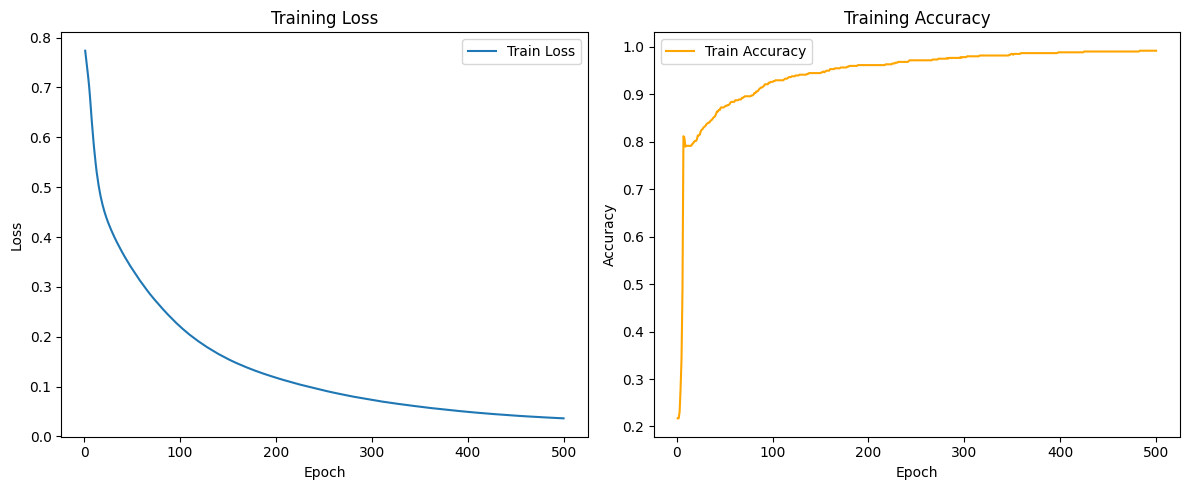

In [25]:
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(outpath + "training_progress.png", dpi=300)
plt.show()

### Test Data

In [57]:
st = read(datapath + "241122Tainan.mseed")
st2 = st.slice(UTCDateTime(2024, 11, 22, 12, 40, 30), UTCDateTime(2024, 11, 22, 12, 40, 35))
st2 = st2.normalize()
st2 = st2.detrend("linear")
X_test = torch.tensor(np.array([i.data for i in st2]))
Y_test = torch.tensor(np.array([1 if i.stats.station in ["ALS", "ELD", "PNG", "SPT", "SSD", "WDL", 
                                                         "WGK", "WNT", "WTC", "WYL", "YUS"] else 0 for i in st2]))

waveforms, stations, labels = [], [], []
for i in st2:
    waveforms.append(i.data)
    stations.append(i.stats.station)
    if i.stats.station in ["ALS", "ELD", "PNG", "SPT", "SSD", "WDL", "WGK", "WNT", "WTC", "WYL", "YUS"]:
        labels.append(1)
    else:
        labels.append(0)

test_data = DataLoader(TensorDataset(X_test, Y_test), batch_size = 3, shuffle =True)
dataset = SeismicDataset(waveforms, labels, stations)
loader = DataLoader(dataset, batch_size = 3, shuffle =True)

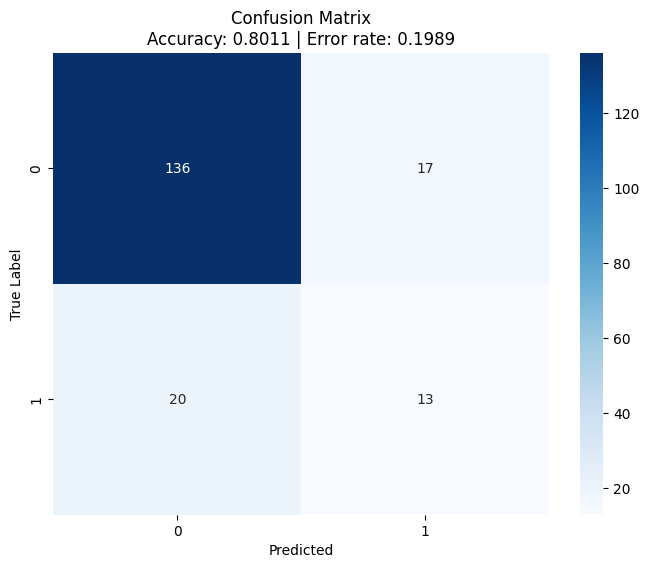

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = []
all_labels = []


with torch.no_grad():
    for xb, yb in test_data:
        xb = xb.float()
        pred = model(xb).argmax(1)   
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
total = cm.sum()
correct = np.trace(cm)
incorrect = total - correct

accuracy = correct / total
error_rate = incorrect / total

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.4f} | Error rate: {error_rate:.4f}")
plt.savefig(outpath + "Confusion_Matrix", dpi = 300)
plt.show()

In [50]:
import matplotlib.pyplot as plt

wrong = []
model.eval()
with torch.no_grad():
    for xb, yb, stn in loader:
        xb = xb.float()
        out = model(xb)
        pred = out.argmax(1)
        for i in range(len(pred)):
            if pred[i] != yb[i]:
                wrong.append({
                    "station": stn[i],
                    "true": yb[i].item(),
                    "pred": pred[i].item(),
                    "waveform": xb[i].numpy()
                })

a = 0
for e in wrong:
    plt.figure(figsize=(10, 3))
    plt.plot(e["waveform"], color='k')
    plt.title(f"Station: {e['station']} | True: {e['true']} | Predicted: {e['pred']}")
    plt.xlabel("Time Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.savefig(outpath + "PreError/" + str(a) + "_" + e['station'] + ".png", dpi = 300);
    plt.close()
    print(f"Station: {e['station']}")
    a += 1

Station: SGS
Station: SPT
Station: ALS
Station: SGL
Station: TIPB
Station: WSF
Station: EHP
Station: SCL
Station: TAI
Station: CHY
Station: PNG
Station: WNT
Station: WCH1
Station: SPT
Station: SSD
Station: NWF
Station: WTP
Station: WDL
Station: WYL
Station: ELD
Station: WGK
Station: ELD
Station: YUS
Station: WGK
Station: TAI1
Station: NJN
Station: ALS
Station: WTP
Station: WTC
Station: WDL
Station: TAI
Station: WYL
Station: CHN8
Station: ECL
